In [1]:
# imports
import os
import time
import numpy as np
import tensorflow as tf
print(tf.__version__)
import gym
import random
from collections import deque
import matplotlib.pyplot as plt
# choose a GPU card
os.environ['CUDA_VISIBLE_DEVICES']="2"

1.15.0


In [2]:
class PolicyNetwork(object):

    def __init__(self, state_size, action_size, learning_rate, name='PolicyNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate

        with tf.variable_scope(name):
            with tf.name_scope("inputs"):
                self.inputs = tf.placeholder(tf.float32, [None,state_size], name = "inputs_")
                # Jieda note: we are using sparse_softmax_cross_entropy_with_logits, so action is now a scaler (instead of a vector)
                self.actions = tf.placeholder(tf.int32, [None,], name ="actions")
                self.discounted_episode_rewards = tf.placeholder(tf.float32, [None,], name="discounted_episode_rewards_")
                # Jieda note: place holder for the ValueNetwork esitimated value
                # Jieda note: following line is commented out, because feed the results from dis_sample_total_rewards - value_estimates
                # directly to discounted_episode_rewards
                # self.value_estimate = tf.placeholder(tf.float32, [None,], name="value_estimate_")

            with tf.name_scope("fc1"):
                self.fc1 = tf.layers.dense(inputs=self.inputs,
                                          units = 256, activation = tf.nn.relu,
                                          kernel_initializer = tf.contrib.layers.xavier_initializer(), name = "fc1")

            with tf.name_scope("fc2"):
                self.fc2 = tf.layers.dense(inputs = self.fc1,
                                           units = 256, activation = tf.nn.relu,
                                           kernel_initializer = tf.contrib.layers.xavier_initializer(), name = 'fc2')

            with tf.name_scope("logits"):
                self.logits = tf.layers.dense(inputs = self.fc2,
                                              units = action_size,
                                              kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                              activation = None)
            with tf.name_scope("softmax"):
                self.action_distribution = tf.nn.softmax(self.logits)

            with tf.name_scope("loss"):
                self.cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = self.logits, labels =self.actions)
                # Jieda noted: for baseline, we subtract the value_estimate_ from discounted_episode_rewards
                self.weighted_negative_likelihoods = tf.multiply(self.cross_entropy, (self.discounted_episode_rewards))
                self.loss = tf.reduce_mean(self.weighted_negative_likelihoods)

            with tf.name_scope("train"):
                self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
                self.train_opt = self.optimizer.minimize(self.loss)



In [3]:
## Define the value function network
## input is the size of state, output is a single value
class ValueNetwork(object):

    def __init__(self, state_size, learning_rate, name='ValueNetwork'):
        self.state_size = state_size
        self.learning_rate = learning_rate

        with tf.variable_scope(name):
            with tf.name_scope("inputs"):
                self.inputs = tf.placeholder(tf.float32, [None,state_size], name = "inputs_")
                self.target = tf.placeholder(tf.float32, [None,], name = "target")

            with tf.name_scope("value_fc1"):
                self.fc1 = tf.layers.dense(inputs=self.inputs,
                                          units = 256, activation = tf.nn.relu,
                                          kernel_initializer = tf.contrib.layers.xavier_initializer(), name = "value_fc1")

            with tf.name_scope("value_fc2"):
                self.fc2 = tf.layers.dense(inputs = self.fc1,
                                           units = 256, activation = tf.nn.relu,
                                           kernel_initializer = tf.contrib.layers.xavier_initializer(), name = 'value_fc2')
            with tf.name_scope("output"):
                self.output_layer = tf.layers.dense(
                inputs=self.fc2,
                units = 1,
                activation = None,
                kernel_initializer = tf.contrib.layers.xavier_initializer(), name = "output")
            
            
            with tf.name_scope("loss"):
                self.value_estimate = tf.squeeze(self.output_layer)
                self.loss = tf.squared_difference(self.value_estimate, self.target)

            with tf.name_scope("train"):
                self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
                self.train_opt = self.optimizer.minimize(self.loss)
    
    
    # method to update the Value neuron network parameters
    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = {self.inputs: state, self.target:target}
        _, loss = sess.run([self.train_opt, self.loss], feed_dict)
        
        return loss

In [4]:
## Helper function
### calculates the discounted total rewards from current step onward

def discount_rewards(r, gamma=0.95, normalization=False):
    """
    computes the discounted rewards from time t onward for a given episode
    length of r corresponds to the number of steps in an episode
    discounted_r has the same length --> discounted rewards at each time step
    """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for i in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[i]
        discounted_r[i] = running_add

    if normalization:
        mean = np.mean(discounted_r)
        std = np.std(discounted_r)
        discounted_r = (discounted_r - mean) / (std)

    return discounted_r

In [5]:
## load environment
env = gym.make('CartPole-v0')

# environment parameters
state_size = 4
action_size = env.action_space.n
possible_actions = np.identity(action_size,dtype=int).tolist()

# training hyperparameters
learning_rate = 0.002
num_epochs = 200
batch_size = 1000 # each 1 is a timestep (not an episode)

In [6]:
#============================
# run policy
#============================
def make_batch(batch_size):

    """
    We will run the policy and generate a bunch of episodes
    We need to keep track of (st,at,rt,st+1) for each of the episode, those we will use for training
    :param batch_size: number of episodes in a batch
    :return: 3 list: states, actions, rewards of batch (each value is accumulated discounted total rewards)
    """
    # initialize lists:

    states, actions, rewards_of_episode, rewards_of_batch, discounted_rewards = [], [], [], [], []
    # number of episode in batch
    episode_num = 1

    # Get a new state
    state = env.reset()

    while True:
        # run state through policy and calculate action
        action_probability_distribution = sess.run(PolicyNetwork.action_distribution, feed_dict={PolicyNetwork.inputs: state.reshape(1,state_size)})

        # choose action
        action = np.random.choice(range(action_probability_distribution.shape[1]), p=action_probability_distribution.ravel())

        # perform action
        next_state, reward, done, info = env.step(action)

        # the 3 lists here tracks the quantity for each episode
        # the other 2 lists (rewards_of_batch and discounted_rewards, they are both list of list)
        # they contain num_episode list and each list is the rewards of that episode of each time stamp
        # rewards_of_batch is UNdiscounted, discounted_rewards is DISCOUNTED and counts from time t onwards
        # in the calculation of loss function, we need the discounted_rewards
        states.append(state)
        actions.append(action)
        rewards_of_episode.append(reward)

        if done:
            # if the entire episode is done

            # if you have more than 1 episode in a batch, we track rewards of each episode in the batch
            # this is undiscounted rewards, we WILL use this to do the plotting
            rewards_of_batch.append(rewards_of_episode)

            # disc_rwds_per_episode is a list with each element being the discounted reward from a time stamp t onward
            disc_rwds_per_episode = discount_rewards(rewards_of_episode, gamma=0.99, normalization=True)
            # discounted_rewards is a list of lenth (number of episode)
            discounted_rewards.append(disc_rwds_per_episode)
            #
            if len(np.concatenate(rewards_of_batch)) > batch_size:
                break
            # reset the transition stores
            rewards_of_episode = []
            # add episode
            episode_num += 1
            # reset the state
            state = env.reset()

        else:
            # if not done, the next_state become the current state
            state = next_state

    # Essentially, we will keep records of (state, action, rewards), need those for training!
    return np.stack(np.array(states)), np.stack(np.array(actions)), np.concatenate(rewards_of_batch), np.concatenate(discounted_rewards),episode_num


In [7]:
# reset the graph
tf.reset_default_graph()
# tf.reset_default_graph()
#==============================
#  Initialize network and session
#==============================
# Instantiate the PolicyNetwork
PolicyNetwork = PolicyNetwork(state_size, action_size, learning_rate)
# Instantiate the ValueNetwork
ValueNetwork = ValueNetwork(state_size, learning_rate)
# Initialize session
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch:  1 / 500
Number of training episodes: 30
Total reward: 1031.0
Mean Reward of that batch 34.36666666666667
Average Reward of all training: 34.36666666666667
Max reward for a batch so far: 0
Epoch:  2 / 500
Number of training episodes: 26
Total reward: 1043.0
Mean Reward of that batch 40.11538461538461
Average Reward of all training: 37.241025641025644
Max reward for a batch so far: 0
Epoch:  3 / 500
Number of training episodes: 26
Total reward: 1041.0
Mean Reward of that batch 40.03846153846154
Average Reward of all training: 38.17350427350428
Max reward for a batch so far: 0
Epoch:  4 / 500
Number of training episodes: 30
Total reward: 1013.0
Mean Reward of that batch 33.766666666666666
Average Reward of all training: 37.07179487179488
Max reward for a batch so far: 0
Epoch:  5 / 500
Number of training episodes: 25
Total reward: 1040.0
Mean Reward of that batch 41.6
Average Reward of all training: 37.9774358974359
Max reward for a batch so far: 0
Epoch:  6 / 500
Number of traini

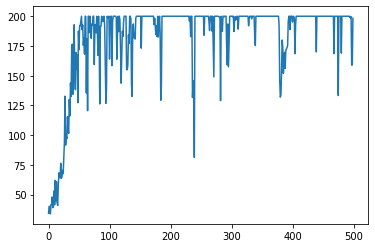

In [11]:
#===================
# Training and Printing some stats
#===================
allRewards =[]
total_rewards =0
maximumRewardRecorded =0
mean_reward_total =[]
average_reward=[]
training = True
num_epochs = 500
epoch = 1

# saver
saver = tf.train.Saver()

if training:
    while epoch < num_epochs +1:
        states_mb, actions_mb, rewards_of_batch, discounted_rewards_mb, nb_episodes_mb = make_batch(1000)
        # total rewards of the batch
        total_reward_of_that_batch = np.sum(rewards_of_batch)
        allRewards.append(total_reward_of_that_batch)

        # calculate the mean reward of the batch
        mean_reward_of_that_batch = np.divide(total_reward_of_that_batch, nb_episodes_mb)
        mean_reward_total.append(mean_reward_of_that_batch)

        # calculate the average reward of all training
        average_reward_of_all_training = np.divide(np.sum(mean_reward_total), epoch)

        # maximum reward recorded
        max_reward_recorded = np.amax(allRewards)

        print("===============================")
        print("Epoch: ", epoch, "/", num_epochs)
        print("Number of training episodes: {}".format(nb_episodes_mb))
        print("Total reward: {}".format(total_reward_of_that_batch, nb_episodes_mb))
        print("Mean Reward of that batch {}".format(mean_reward_of_that_batch))
        print("Average Reward of all training: {}".format(average_reward_of_all_training))
        print("Max reward for a batch so far: {}".format(maximumRewardRecorded))
        
        # Jieda note: update the ValueNetwork parameter, and make an estimate of Value function for each given St
        feed_dict_value = {ValueNetwork.inputs:states_mb, ValueNetwork.target:discounted_rewards_mb}
        _, loss = sess.run([ValueNetwork.train_opt, ValueNetwork.loss], feed_dict_value)
        
        # Now make a prediction of value function using the updated ValueNetwork parameters    
        value_prediction = sess.run(ValueNetwork.value_estimate, {ValueNetwork.inputs: states_mb})

        # Jieda note: compute the discounted total rewards minus baseline
        # shape of discounted_rewards_mb should be an array of length (number of 4 tuples in that batch)
        # shape of value_prediction should also be an array of length (number of 4 tuples in that batch)
        # Note: 4 tuples are essentially samples (st,at,rt,st+1)
        discounted_rewards_mb_minus_baseline = discounted_rewards_mb - value_prediction
        
        # Now update the Policy Network with a baseline that is the ValueNetwork Prediction
        loss_,_ = sess.run([PolicyNetwork.loss,PolicyNetwork.train_opt], \
                feed_dict={PolicyNetwork.inputs: states_mb, PolicyNetwork.actions: actions_mb, PolicyNetwork.discounted_episode_rewards: discounted_rewards_mb_minus_baseline})

        # update epoch
        epoch +=1

# plot the average episode reward vs epoch
# episode reward is the total undiscounted reward for an episode
plt.plot(range(0,len(mean_reward_total)), mean_reward_total)
plt.savefig('./average_reward_vs_epoch_baseline.png')

In [ ]:
# plot the average reward over epochs
